Extracting ../data/fashion/train-images-idx3-ubyte.gz
Extracting ../data/fashion/train-labels-idx1-ubyte.gz
Extracting ../data/fashion/t10k-images-idx3-ubyte.gz
Extracting ../data/fashion/t10k-labels-idx1-ubyte.gz


/home/linwei/.virtualenvs/jupyter_env3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/linwei/.virtualenvs/jupyter_env3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[[  2.7431438   10.10497379]
 [  1.0811075   -4.22779703]
 [  0.64393371   6.42355919]
 [  0.74329782   2.30190134]
 [         nan          nan]
 [ -1.00761807  -1.03102398]
 [  6.09323072  -1.27415848]
 [  3.1768806    7.41346979]
 [  3.96189165   5.76764345]
 [  2.88838315  -2.17946339]]


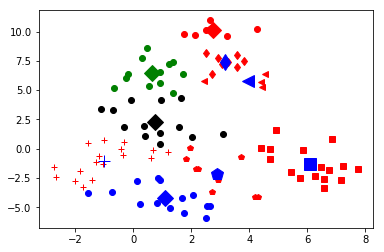

In [3]:
from numpy import *
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.manifold import TSNE    # 降维处理


# 欧式距离
def calDistance(x1, x2):
    return linalg.norm(x1 - x2)


# 生成随机聚类中心
def initCentroids(dataSet, k):
    n = shape(dataSet)[1]
    clustercents = mat(zeros((k, n)))  # 初始化聚类中心矩阵：k * n
    for col in range(n):
        mincol = min(dataSet[:, col])
        maxcol = max(dataSet[:, col])

        # randoom.rand（k, 1）：产生一个0-1之间的随机数向量；K， 1表示产生k行1列的随机数
        clustercents[:, col] = mat(mincol + float(maxcol - mincol) * random.rand(k, 1))
    return clustercents


def KMeansr(dataSet, k):
    m = shape(dataSet)[0]
    # 与数据集等长，共两列，第一列：数据集对应的聚类中心k；第二列：数据集到聚类中心的距离
    ClustDist = mat(zeros((m, 2)))

    clustercents = initCentroids(dataSet, k)
    # 标志位
    flag = True
    while flag:
        flag = False
        for i in range(m):
            distlist = [calDistance(clustercents[j, :], dataSet[i, :]) for j in range(k)]
            minDist = min(distlist)
            minIndex = distlist.index(minDist)

            if ClustDist[i, 0] != minIndex:
                flag = True
            ClustDist[i, :] = minIndex, minDist

        for cent in range(k):
            ptsInClust = dataSet[nonzero(ClustDist[:, 0].A == cent)[0]]
            clustercents[cent, :] = mean(ptsInClust, axis=0)

    return clustercents, ClustDist


def show(dataSet, k, clustercents, ClustDist):
    numSamples, _ = shape(dataSet)
    mark = ['or', 'ob', 'og', 'ok', '^r', '+r', 'sr', 'dr', '<r', 'pr']
    for i in range(numSamples):
        markIndex = int(ClustDist[i, 0])
        plt.plot(dataSet[i, 0], dataSet[i, 1], mark[markIndex])
    mark = ['Dr', 'Db', 'Dg', 'Dk', '^b', '+b', 'sb', 'db', '<b', 'pb']
    for i in range(k):
        plt.plot(clustercents[i, 0], clustercents[i, 1], mark[i], markersize=12)
    plt.show()

def main():
    mnist = input_data.read_data_sets('../data/fashion', one_hot=True)
    train_images = mnist.train.images
    # print(train_images)
    dataMat = TSNE().fit_transform(train_images[:100])
    # dataMat = loadtxt('test.txt')
    myCentroids, ClustDist = KMeansr(dataMat, 10)
    print(myCentroids)
    show(dataMat, 10, myCentroids, ClustDist)

if __name__ == '__main__':
    main()

In [ ]:
from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib.tensor_forest.python import tensor_forest

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

#输入数据
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../data/fashion", one_hot=False)


# 参数
# Parameters
num_steps = 100 # Total steps to train
batch_size = 1024# The number of samples per batch
num_classes = 10 # The 10 digits
num_features = 784 # Each image is 28x28 pixels
num_trees = 10
max_nodes = 1000

# 输入和目标数据
X = tf.placeholder(tf.float32, shape=[None, 784])
# 对于随机森林，标签必须是整数(类id)
Y = tf.placeholder(tf.int32, shape=[None])

# Random Forest Parameters
hparams = tensor_forest.ForestHParams(num_classes=num_classes,
                                      num_features=num_features,
                                      num_trees=num_trees,
                                      max_nodes=max_nodes).fill()

forest_graph = tensor_forest.RandomForestGraphs(hparams)
train_op = forest_graph.training_graph(X, Y)
loss_op = forest_graph.training_loss(X, Y)

# 测量的精确度
infer_op = forest_graph.inference_graph(X)
correct_prediction = tf.equal(tf.argmax(infer_op, 1), tf.cast(Y, tf.int64))#tf.equal(A, B)是对比这两个矩阵或者向量的相等的元素，如果是相等的那就返回True，反正返回False，返回的值的矩阵维度和A是一样的
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) #tf.cast是类型转换函数  tf.reduce_mean()是求平均值

# 启动会话
sess = tf.Session()
# 运行初始化
sess.run(tf.global_variables_initializer())
# 训练
for i in range(1, num_steps + 1):
    # 准备数据
    # 获取下一批MNIST数据(只需要图像，不需要标签)
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    _, l = sess.run([train_op, loss_op], feed_dict={X: batch_x, Y: batch_y})
    if i in range(num_steps):
        acc = sess.run(accuracy_op, feed_dict={X: batch_x, Y: batch_y})
        print('Step %i, 损失 %f, Acc: %f,' % (i, l, acc))
# 测试模板
test_x, test_y = mnist.test.images, mnist.test.labels
print("Test Accuracy:", sess.run(accuracy_op, feed_dict={X: test_x, Y: test_y}))

Extracting ../data/fashion/train-images-idx3-ubyte.gz
Extracting ../data/fashion/train-labels-idx1-ubyte.gz
Extracting ../data/fashion/t10k-images-idx3-ubyte.gz
Extracting ../data/fashion/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Constructing forest with params = 
INFO:tensorflow:{'num_trees': 10, 'max_nodes': 1000, 'bagging_fraction': 1.0, 'feature_bagging_fraction': 1.0, 'num_splits_to_consider': 784, 'max_fertile_nodes': 500, 'split_after_samples': 250, 'min_split_samples': 5, 'valid_leaf_threshold': 1, 'dominate_method': 'bootstrap', 'dominate_fraction': 0.99, 'num_classes': 10, 'num_features': 784, 'bagged_num_features': 784, 'bagged_features': None, 'regression': False, 'num_outputs': 1, 'num_output_columns': 11, 'split_initializations_per_input': 3, 'base_random_seed': 0}
INFO:tensorflow:training graph for tree: 0
INFO:tensorflow:training graph for tree: 1
INFO:tensorflow:training graph for tree: 2
INFO:tensorflow:training graph for tree: 3
INFO:tensorflow:training graph for tre